# Feasibility Studies for Smartwatch

We're interested in a few things, but I'll probably hash them out properly later

### Response Rate
How often a participant entered a "No response", per day of the study

In [1]:
"""
Find "No response" rate per user per day of the study

"""
import pandas as pd
import numpy as np
from typing import Union

from ema import clean

meal_info = clean.cleaned_smartwatch(remove_catchups=True)


def fraction(positive: pd.Series, negative: pd.Series) -> float:
    """
    Given two series of positive and negative responses, find the fraction of positive responses

    """
    return len(positive) / (len(positive) + len(negative))


def fraction_err(positive: pd.Series, negative: pd.Series) -> float:
    """
    Given two series of positive and negative responses, find error on the fraction of positive responses

    """
    # I think this is right...
    return fraction(positive, negative) * np.sqrt(1 / (len(positive) + len(negative)))


def fraction_per_day(meal_df: pd.DataFrame, label: Union[str, list]) -> tuple:
    """
    Get the fraction per day and its error for a specified type of meal_type

    """
    if isinstance(label, str):
        label = [label]

    all_labels = ["Meal", "Snack", "Drink", "No food/drink", "No response"]
    for l in label:
        assert l in all_labels, l

    # Iterate over days, slicing per day and finding the fraction of responses
    fractions, errors = [], []

    for day in range(1, 8):
        # Find how many positive and negative responses on each day
        mask = (meal_df["delta"] > pd.Timedelta(days=day)) & (
            meal_df["delta"] < pd.Timedelta(days=day + 1)
        )
        meals_on_this_day = meal_df[mask]
        positive = meals_on_this_day[meals_on_this_day["meal_type"].isin(label)]
        negative = meals_on_this_day[
            meals_on_this_day["meal_type"].isin(
                [l for l in all_labels if l not in label]
            )
        ]

        # Find the fraction of positive responses
        fractions.append(fraction(positive, negative))

        # Find its uncertainty by bootstrapping

        # Find the standard deviation of the fractions
        # This is the error
        errors.append(fraction_err(positive, negative))

    return np.array(fractions), np.array(errors)

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


/tmp/ipykernel_23625/939264812.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f"Day {i}" for i in range(8)])


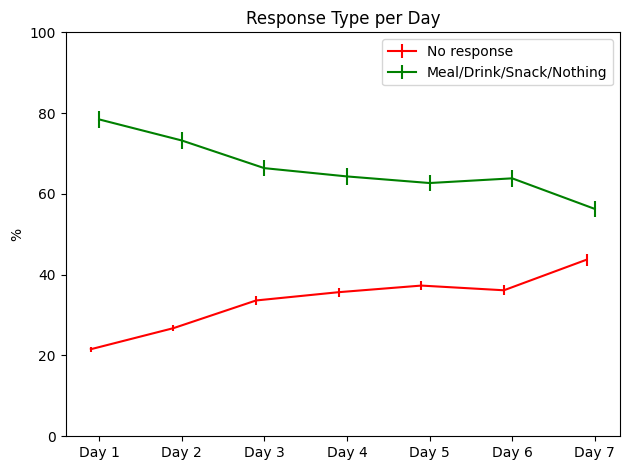

In [2]:
"""
Plot them

"""
import matplotlib.pyplot as plt


def plot(
    axis: plt.Axes, fractions: np.ndarray, errs: np.ndarray, x_ticks, **plot_kw
) -> None:
    """
    Plot the specified fractions and errors on the provided axis

    """
    axis.errorbar(
        x_ticks,
        100 * fractions,
        yerr=100 * errs,
        fmt="-",
        **plot_kw,
    )


fig, axis = plt.subplots()

plot(
    axis,
    *fraction_per_day(meal_info, "No response"),
    np.arange(1, 8) - 0.1,
    label="No response",
    color="r",
)
plot(
    axis,
    *fraction_per_day(meal_info, ["Meal", "Drink", "Snack", "No food/drink"]),
    np.arange(1, 8),
    label="Meal/Drink/Snack/Nothing",
    color="g",
)

axis.set_xticklabels([f"Day {i}" for i in range(8)])

axis.set_ylim(0, 100)
axis.set_title("Response Type per Day")
axis.set_ylabel("%")
axis.legend()

fig.tight_layout()
fig.savefig("img/response_types.png")

It looks like the response rate goes down during the study, but we want to formally check this.

Let's do this with a multilevel model; we want to check whether a positive/negative is are predicted by the day of the study for each participant.
To do this we'll make a dataframe holding the day of the study, the participant ID and whether each entry was a no-response

In [45]:
"""
Multilevel model for no response rate

"""
import patsy
import statsmodels as sm

meal_info = clean.cleaned_smartwatch(remove_catchups=True)

# Create a dataframe holding the right information
model_df = pd.DataFrame()

# Participant ID and entry day
model_df["p_id"] = meal_info["p_id"]
model_df["day"] = meal_info["delta"].dt.days

# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)

# Need to create a design matrix for the random effects
exog_vc = patsy.dmatrix("0 + C(p_id)", model_df, return_type="dataframe")

# Do the multilevel model
model = sm.genmod.bayes_mixed_glm.BinomialBayesMixedGLM(
    endog=model_df["entry"],  # The responses
    exog=sm.tools.tools.add_constant(model_df["day"]),  # The fixed part
    exog_vc=exog_vc,  # Covariates
    ident=np.ones(
        model_df["p_id"].nunique(), dtype=int
    ),  # This tells us which random effects have a common variance - in our case, all of them
    # vcp_p=0.5,  # I think the documentation says this might be better
)
result = model.fit_map()

print(result.summary())
model_df.to_csv("meal_info.csv")

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


             Binomial Mixed GLM Results
      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------
const    M     1.5604   0.1228                      
day      M    -0.2345   0.0126                      
VC_1     V     0.0000   1.0000 1.000   0.135   7.389
VC_2     V    -0.0222   0.0899 0.978   0.817   1.171
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


In [49]:
from pymer4.models import Lmer

# Fit the model
model = Lmer('entry ~ day + (1|p_id)', data=model_df, family='binomial')

# Print the model summary
print(model.fit())

/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


PackageNotInstalledError: The R package "lme4" is not installed.

In [50]:
%load_ext rpy2.ipython

In [54]:
%%R -w 5 -h 5 --units in -r 200

install.packages("tidyverse")
library(tidyverse)

* installing *source* package ‘curl’ ...
** package ‘curl’ successfully unpacked and MD5 sums checked
** using staged installation
Package libcurl was not found in the pkg-config search path.
Perhaps you should add the directory containing `libcurl.pc'
to the PKG_CONFIG_PATH environment variable
No package 'libcurl' found
Package libcurl was not found in the pkg-config search path.
Perhaps you should add the directory containing `libcurl.pc'
to the PKG_CONFIG_PATH environment variable
No package 'libcurl' found
ERROR: configuration failed for package ‘curl’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/curl’


Using PKG_CFLAGS=
Using PKG_LIBS=-lcurl
--------------------------- [ANTICONF] --------------------------------
Configuration failed because libcurl was not found. Try installing:
 * deb: libcurl4-openssl-dev (Debian, Ubuntu, etc)
 * rpm: libcurl-devel (Fedora, CentOS, RHEL)
If libcurl is already installed, check that 'pkg-config' is in your
PATH and PKG_CONFIG_PATH contains a libcurl.pc file. If pkg-config
is unavailable you can set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
-------------------------- [ERROR MESSAGE] ---------------------------
<stdin>:1:10: fatal error: curl/curl.h: No such file or directory
compilation terminated.
--------------------------------------------------------------------


* installing *source* package ‘openssl’ ...
** package ‘openssl’ successfully unpacked and MD5 sums checked
** using staged installation
ERROR: configuration failed for package ‘openssl’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/openssl’
* installing *source* package ‘systemfonts’ ...
** package ‘systemfonts’ successfully unpacked and MD5 sums checked
** using staged installation
Package fontconfig was not found in the pkg-config search path.
Perhaps you should add the directory containing `fontconfig.pc'
to the PKG_CONFIG_PATH environment variable
No package 'fontconfig' found
Package freetype2 was not found in the pkg-config search path.
Perhaps you should add the directory containing `freetype2.pc'
to the PKG_CONFIG_PATH environment variable
No package 'freetype2' found


Using PKG_CFLAGS=
--------------------------- [ANTICONF] --------------------------------
Configuration failed because openssl was not found. Try installing:
 * deb: libssl-dev (Debian, Ubuntu, etc)
 * rpm: openssl-devel (Fedora, CentOS, RHEL)
 * csw: libssl_dev (Solaris)
 * brew: openssl (Mac OSX)
If openssl is already installed, check that 'pkg-config' is in your
PATH and PKG_CONFIG_PATH contains a openssl.pc file. If pkg-config
is unavailable you can set INCLUDE_DIR and LIB_DIR manually via:
R CMD INSTALL --configure-vars='INCLUDE_DIR=... LIB_DIR=...'
-------------------------- [ERROR MESSAGE] ---------------------------
tools/version.c:1:10: fatal error: openssl/opensslv.h: No such file or directory
    1 | #include <openssl/opensslv.h>
      |          ^~~~~~~~~~~~~~~~~~~~
compilation terminated.
--------------------------------------------------------------------
Using PKG_CFLAGS=
Using PKG_LIBS=-lfontconfig -lfreetype
--------------------------- [ANTICONF] ----------------------

ERROR: configuration failed for package ‘systemfonts’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/systemfonts’
* installing *source* package ‘xml2’ ...
** package ‘xml2’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/home/mh19137/anaconda3/envs/malaysia310/include/libxml2 -I/home/mh19137/anaconda3/envs/malaysia310/include
Using PKG_LIBS=-L/home/mh19137/anaconda3/envs/malaysia310/lib -lxml2 -L/home/mh19137/anaconda3/envs/malaysia310/lib -lz -L/home/mh19137/anaconda3/envs/malaysia310/lib -llzma -L/home/mh19137/anaconda3/envs/malaysia310/lib -L/home/mh19137/anaconda3/envs/malaysia310/lib -licui18n -licuuc -licudata -lm -ldl
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/home/mh19137/anaconda3/envs/malaysia310/include/libxml2 -I/home/mh19137/anaconda3/envs/malaysia310/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0    -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c connection.cpp -o connection.o


** libs


gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/home/mh19137/anaconda3/envs/malaysia310/include/libxml2 -I/home/mh19137/anaconda3/envs/malaysia310/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c init.c -o init.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/home/mh19137/anaconda3/envs/malaysia310/include/libxml2 -I/home/mh19137/anaconda3/envs/malaysia310/include -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0    -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c xml2_doc.cpp -o xml2_doc.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/home/mh19137/anaconda3/envs/malaysia310/include/libxml2 -I/home/mh19137/anaconda3/envs/mal

installing to /home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-xml2/00new/xml2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location


** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xml2)
ERROR: dependency ‘openssl’ is not available for package ‘ids’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/ids’
ERROR: dependency ‘systemfonts’ is not available for package ‘textshaping’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/textshaping’
ERROR: dependencies ‘curl’, ‘openssl’ are not available for package ‘httr’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/httr’
ERROR: dependencies ‘httr’, ‘openssl’ are not available for package ‘gargle’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/gargle’
ERROR: dependencies ‘systemfonts’, ‘textshaping’ are not available for package ‘ragg’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/ragg’
ERROR: dependency ‘httr’ is not available for package ‘rvest’

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning in install.packages("tidyverse") :
  'lib = "/usr/local/lib/R/site-library"' is not writable
also installing the dependencies ‘gargle’, ‘curl’, ‘ids’, ‘openssl’, ‘systemfonts’, ‘textshaping’, ‘googledrive’, ‘googlesheets4’, ‘httr’, ‘ragg’, ‘rvest’, ‘xml2’

trying URL 'https://cloud.r-project.org/src/contrib/gargle_1.5.2.tar.gz'
Content type 'application/x-gzip' length 627560 bytes (612 KB)
downloaded 612 KB

trying URL 'https://cloud.r-project.org/src/contrib/curl_5.1.0.tar.gz'
Content type 'application/x-gzip' length 714157 bytes (697 KB)
downloaded 697 KB

trying URL 'https://cloud.r-project.org/src/contrib/ids_1.0.1.tar.gz'
Content type 'application/x-gzip' length 91213 bytes (89 KB)
downloaded 89 KB

trying URL 'https://cloud.r-project.org/src/contrib/openssl_2.1.1.tar.gz'
Content type 'application/x-gzip' length 1206233 bytes (1.2 MB)
downloaded 1.2 MB

trying URL 'https://cloud.r-project.org

ERROR: dependencies ‘googledrive’, ‘googlesheets4’, ‘httr’, ‘ragg’, ‘rvest’ are not available for package ‘tidyverse’
* removing ‘/home/mh19137/R/x86_64-pc-linux-gnu-library/4.1/tidyverse’


RInterpreterError: Failed to parse and evaluate line '\ninstall.packages("tidyverse")\nlibrary(tidyverse)\n'.
R error message: 'Error in library(tidyverse) : there is no package called ‘tidyverse’'
R stdout:
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Warning in install.packages("tidyverse") :
  'lib = "/usr/local/lib/R/site-library"' is not writable
also installing the dependencies ‘gargle’, ‘curl’, ‘ids’, ‘openssl’, ‘systemfonts’, ‘textshaping’, ‘googledrive’, ‘googlesheets4’, ‘httr’, ‘ragg’, ‘rvest’, ‘xml2’

trying URL 'https://cloud.r-project.org/src/contrib/gargle_1.5.2.tar.gz'
Content type 'application/x-gzip' length 627560 bytes (612 KB)
==================================================
downloaded 612 KB

trying URL 'https://cloud.r-project.org/src/contrib/curl_5.1.0.tar.gz'
Content type 'application/x-gzip' length 714157 bytes (697 KB)
==================================================
downloaded 697 KB

trying URL 'https://cloud.r-project.org/src/contrib/ids_1.0.1.tar.gz'
Content type 'application/x-gzip' length 91213 bytes (89 KB)
==================================================
downloaded 89 KB

trying URL 'https://cloud.r-project.org/src/contrib/openssl_2.1.1.tar.gz'
Content type 'application/x-gzip' length 1206233 bytes (1.2 MB)
==================================================
downloaded 1.2 MB

trying URL 'https://cloud.r-project.org/src/contrib/systemfonts_1.0.5.tar.gz'
Content type 'application/x-gzip' length 80638 bytes (78 KB)
==================================================
downloaded 78 KB

trying URL 'https://cloud.r-project.org/src/contrib/textshaping_0.3.7.tar.gz'
Content type 'application/x-gzip' length 35100 bytes (34 KB)
==================================================
downloaded 34 KB

trying URL 'https://cloud.r-project.org/src/contrib/googledrive_2.1.1.tar.gz'
Content type 'application/x-gzip' length 1609266 bytes (1.5 MB)
==================================================
downloaded 1.5 MB

trying URL 'https://cloud.r-project.org/src/contrib/googlesheets4_1.1.1.tar.gz'
Content type 'application/x-gzip' length 232584 bytes (227 KB)
==================================================
downloaded 227 KB

trying URL 'https://cloud.r-project.org/src/contrib/httr_1.4.7.tar.gz'
Content type 'application/x-gzip' length 118500 bytes (115 KB)
==================================================
downloaded 115 KB

trying URL 'https://cloud.r-project.org/src/contrib/ragg_1.2.6.tar.gz'
Content type 'application/x-gzip' length 425391 bytes (415 KB)
==================================================
downloaded 415 KB

trying URL 'https://cloud.r-project.org/src/contrib/rvest_1.0.3.tar.gz'
Content type 'application/x-gzip' length 94659 bytes (92 KB)
==================================================
downloaded 92 KB

trying URL 'https://cloud.r-project.org/src/contrib/xml2_1.3.5.tar.gz'
Content type 'application/x-gzip' length 272664 bytes (266 KB)
==================================================
downloaded 266 KB

trying URL 'https://cloud.r-project.org/src/contrib/tidyverse_2.0.0.tar.gz'
Content type 'application/x-gzip' length 704618 bytes (688 KB)
==================================================
downloaded 688 KB


The downloaded source packages are in
	‘/tmp/RtmpIykkuf/downloaded_packages’
Error in library(tidyverse) : there is no package called ‘tidyverse’
In addition: There were 12 warnings (use warnings() to see them)

In [44]:
import pymc as pm

# Define the model
with pm.Model() as model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    day_coef = pm.Normal("day_coef", mu=0, sigma=10)
    p_id_sd = pm.HalfNormal("p_id_sd", sigma=10)
    p_id = pm.Normal("p_id", mu=0, sigma=p_id_sd, shape=model_df["p_id"].nunique())

    # Expected value of outcome (using the logit link function)
    logit_p = intercept + day_coef * model_df["day"] + p_id[model_df["p_id"]]

    # Likelihood
    entry = pm.Binomial(
        "entry", n=1, p=pm.math.invlogit(logit_p), observed=model_df["entry"]
    )

# Fit the model
with model:
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.95)

# Print the summary
pm.summary(trace)

Only 83 samples in chain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


IndexError: index 16231 is out of bounds for axis 0 with size 83
Apply node that caused the error: AdvancedSubtensor1(p_id, [16231 162 ... 055 39055])
Toposort index: 8
Inputs types: [TensorType(float64, shape=(83,)), TensorType(uint16, shape=(7722,))]
Inputs shapes: [(83,), (7722,)]
Inputs strides: [(8,), (2,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Composite{...}(ExpandDims{axis=0}.0, [1. 1. 1. ... 6. 6. 6.], ExpandDims{axis=0}.0, AdvancedSubtensor1.0, [0. 0. 0. ... 1. 0. 0.], [  0.   0. ... 0.   0.], [-inf -inf ... -inf -inf], [1. 1. 1. ... 0. 1. 1.])]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
    result = self._run_cell(
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/mh19137/anaconda3/envs/malaysia310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23625/2987812481.py", line 12, in <module>
    logit_p = intercept + day_coef * model_df["day"] + p_id[model_df["p_id"]]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.